# Machine Learning Foundation

## Course 3, Part b: K-Nearest Neighbor LAB

## Introduction and Learning Goals

In this lab, we explore classification using the K-Nearest Neighbors approach. We use a customer churn dataset from the telecom industry which includes customer data, usage of long-distance, data usage, monthly revenue, type of offerings, and other services purchased by customers. The data, based on a fictional telecom firm, include several Excel files which have been combined and are available in the course materials. We are using the subset of customers who have phone accounts. Since the data include a mix of numeric, categorical, and ordinal variables, we will load this data and do some preprocessing, then use K-nearest neighbors to predict customer churn rates.

After completing this lab, you should have a working understanding of how to preprocess a variety of variables in order to apply the K-Nearest Neighbors algorithm, understand how to choose K, and understand how to evaluate model performance.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os, sys, seaborn as sns
os.chdir('/users/salahkaf/desktop/IBM-Data')
from datasetup import churndata, colors, palette
sns.set_palette(palette)

## Question 1

* We begin by importing the data. Examine the columns and data.
* Notice that the data contains a unique ID, an indicator for phone customer status, total lifetime value, total revenue, and a bank-estimated churn score. We will not be using these features, so they can be dropped from the data.
* Begin by taking an initial look at the data, including both numeric and non-numeric features.

In [2]:
churndata.dtypes

id                object
months             int64
offer             object
phone             object
multiple          object
internet_type     object
gb_mon             int64
security          object
backup            object
protection        object
support           object
unlimited         object
contract          object
paperless         object
payment           object
monthly          float64
total_revenue    float64
satisfaction       int64
churn_value        int64
churn_score        int64
cltv               int64
dtype: object

In [3]:
### BEGIN SOLUTION
df = churndata.drop(columns=['id', 'phone', 'total_revenue', 'cltv', 'churn_score'])

In [4]:
round(df.describe(),2) # 0.27 in churn_value implies ~27% has churned.

,months,gb_mon,monthly,satisfaction,churn_value
count,7043.00,7043.00,7043.00,7043.00,7043.00
mean,32.39,20.52,64.76,3.24,0.27
std,24.54,20.42,30.09,1.20,0.44
min,1.00,0.00,18.25,1.00,0.00
25%,9.00,3.00,35.50,3.00,0.00
50%,29.00,17.00,70.35,3.00,0.00
75%,55.00,27.00,89.85,4.00,1.00
max,72.00,85.00,118.75,5.00,1.00


In [5]:
df.describe(include='object')
### END SOLUTION

,offer,multiple,internet_type,security,backup,protection,support,unlimited,contract,paperless,payment
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,6,2,4,2,2,2,2,2,3,2,3
top,None,No,Fiber Optic,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal
freq,3877,4072,3035,5024,4614,4621,4999,4745,3610,4171,3909


## Question 2

* Identify which variables are binary, categorical and not ordinal, categorical and ordinal, and numeric.  The non-numeric features will need to be encoded using methods we have discussed in the course.
* Start by identifying the number of unique values each variable takes, then create list variables for categorical, numeric, binary, and ordinal variables. 
* Note that the variable 'months' can be treated as numeric, but it may be more convenient to transform it to an ordinal variable.
* For the other categorical variables, examine their values to determine which may be encoded ordinally.

In [6]:
### BEGIN SOLUTION
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

# or
# for i in df.columns:
#     print(i) # Column bane
#     print(len(df[i].unique())) # Count the number of unique values
# Or
# df.nunique()

,Unique Values
Variable,
months,72
offer,6
multiple,2
internet_type,4
gb_mon,50
security,2
backup,2
protection,2
support,2


In [7]:
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
binary_variables

['multiple',
 'security',
 'backup',
 'protection',
 'support',
 'unlimited',
 'paperless',
 'churn_value']

In [8]:
categorical_variables = list(df_uniques[(6 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)
categorical_variables

['offer', 'internet_type', 'contract', 'payment', 'satisfaction']

In [9]:
[[i, list(df[i].unique())] for i in categorical_variables]

[['offer', ['None', 'Offer E', 'Offer D', 'Offer C', 'Offer B', 'Offer A']],
 ['internet_type', ['DSL', 'Fiber Optic', 'Cable', 'None']],
 ['contract', ['Month-to-Month', 'One Year', 'Two Year']],
 ['payment', ['Bank Withdrawal', 'Credit Card', 'Mailed Check']],
 ['satisfaction', [3, 2, 1, 4, 5]]]

In [10]:
ordinal_variables = ['contract', 'satisfaction']

In [11]:
df['months'].unique()

array([ 1,  8, 18, 25, 37, 27, 58, 15,  7, 11,  3, 13, 16, 24,  4, 32, 54,
        2, 21, 55,  5, 20, 65, 49, 43, 56, 52, 33, 30, 46,  9, 10, 35, 44,
       62, 14, 12, 17, 39, 68, 34, 22, 19, 23, 42, 41, 57, 38, 29, 66, 69,
       40, 31, 59, 36, 45, 53, 70, 47, 50, 51, 72, 26,  6, 28, 48, 61, 71,
       60, 64, 67, 63])

In [12]:
ordinal_variables.append('months')

In [13]:
numeric_variables = list(set(df.columns) - set(ordinal_variables) - set(categorical_variables) - set(binary_variables))

array([[<AxesSubplot:title={'center':'monthly'}>,
        <AxesSubplot:title={'center':'gb_mon'}>]], dtype=object)

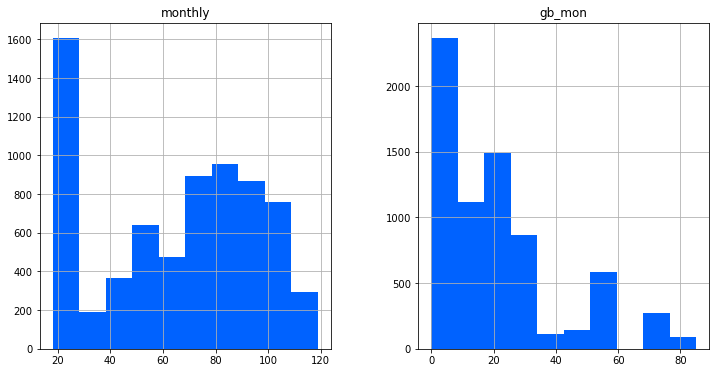

In [14]:
df[numeric_variables].hist(color=colors[0], figsize=(12, 6))

In [15]:
df['months'] = pd.cut(df['months'], bins=5) #Binning
### END SOLUTION

In [16]:
df.months

0       (0.929, 15.2]
1       (0.929, 15.2]
2        (15.2, 29.4]
3        (15.2, 29.4]
4        (29.4, 43.6]
            ...      
7038     (57.8, 72.0]
7039     (15.2, 29.4]
7040     (57.8, 72.0]
7041    (0.929, 15.2]
7042     (57.8, 72.0]
Name: months, Length: 7043, dtype: category
Categories (5, interval[float64, right]): [(0.929, 15.2] < (15.2, 29.4] < (29.4, 43.6] < (43.6, 57.8] < (57.8, 72.0]]

In [17]:
df.contract

0       Month-to-Month
1       Month-to-Month
2       Month-to-Month
3       Month-to-Month
4       Month-to-Month
             ...      
7038          Two Year
7039          One Year
7040          One Year
7041    Month-to-Month
7042          Two Year
Name: contract, Length: 7043, dtype: object

In [18]:
df.satisfaction

0       3
1       3
2       2
3       2
4       2
       ..
7038    5
7039    3
7040    4
7041    4
7042    4
Name: satisfaction, Length: 7043, dtype: int64

## Question 3
* Having set up the variables, remember that the K-nearest neighbors algorithm uses distance and hence requires scaled data. 
* Scale the data using one of the scaling methods discussed in the course.
* Save the processed dataframe as a comma-separated file: 'churndata_processed.csv'

In [19]:
### BEGIN SOLUTION
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder

In [20]:
lb, le = LabelBinarizer(), LabelEncoder() # Initialize encoding objects.
# We can use LabelEncoder for ordinal data if they are alphabetically ordered. (The contract in our case)

In [21]:
print(categorical_variables)
print(ordinal_variables)
print(numeric_variables)

['offer', 'internet_type', 'contract', 'payment', 'satisfaction']
['contract', 'satisfaction', 'months']
['monthly', 'gb_mon']


In [22]:
for column in ordinal_variables:
    df[column] = le.fit_transform(df[column])

In [23]:
df.satisfaction # The 3 becomes 2. The 5 becomes 4. etc.

0       2
1       2
2       1
3       1
4       1
       ..
7038    4
7039    2
7040    3
7041    3
7042    3
Name: satisfaction, Length: 7043, dtype: int64

In [24]:
print(df.satisfaction.unique())
print(df.months.unique())
print(df.contract.unique())

[2 1 0 3 4]
[0 1 2 4 3]
[0 1 2]


**We observe that 3 columns have been encoded** <br>
**Satisfaction 0-4** <br>
**contract 0:2** <br>
**months 0:4**

In [25]:
df[ordinal_variables].astype('category').describe() # Another method to count

,contract,satisfaction,months
count,7043,7043,7043
unique,3,5,5
top,0,2,0
freq,3610,2665,2470


In [26]:
for column in binary_variables:
    df[column] = lb.fit_transform(df[column])

In [27]:
df.head(2)

,months,offer,multiple,internet_type,gb_mon,security,backup,protection,support,unlimited,contract,paperless,payment,monthly,satisfaction,churn_value
0,0,None,0,DSL,8,0,0,1,0,0,0,1,Bank Withdrawal,39.65,2,1
1,0,Offer E,1,Fiber Optic,17,0,1,0,0,1,0,1,Credit Card,80.65,2,1


In [28]:
categorical_variables = list(set(categorical_variables) - set(ordinal_variables))
# To avoid repetitiveness

In [29]:
df = pd.get_dummies(df, columns = categorical_variables, drop_first=True)

In [30]:
df.head(2)

,months,multiple,gb_mon,security,backup,protection,support,unlimited,contract,paperless,...,offer_Offer A,offer_Offer B,offer_Offer C,offer_Offer D,offer_Offer E,internet_type_DSL,internet_type_Fiber Optic,internet_type_None,payment_Credit Card,payment_Mailed Check
0,0,0,8,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0,1,17,0,1,0,0,1,0,1,...,0,0,0,0,1,0,1,0,1,0


In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
months,7043.0,1.734204,1.592924,0.00,0.0,1.00,3.00,4.00
multiple,7043.0,0.421837,0.493888,0.00,0.0,0.00,1.00,1.00
gb_mon,7043.0,20.515405,20.418940,0.00,3.0,17.00,27.00,85.00
security,7043.0,0.286668,0.452237,0.00,0.0,0.00,1.00,1.00
backup,7043.0,0.344881,0.475363,0.00,0.0,0.00,1.00,1.00
protection,7043.0,0.343888,0.475038,0.00,0.0,0.00,1.00,1.00
support,7043.0,0.290217,0.453895,0.00,0.0,0.00,1.00,1.00
unlimited,7043.0,0.673719,0.468885,0.00,0.0,1.00,1.00,1.00
contract,7043.0,0.754792,0.848468,0.00,0.0,0.00,2.00,2.00
paperless,7043.0,0.592219,0.491457,0.00,0.0,1.00,1.00,1.00


In [32]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

In [33]:
for column in [ordinal_variables + numeric_variables]:
    df[column] = mm.fit_transform(df[column])

In [34]:
round(df.describe().T, 3)

,count,mean,std,min,25%,50%,75%,max
months,7043.0,0.434,0.398,0.0,0.000,0.250,0.750,1.0
multiple,7043.0,0.422,0.494,0.0,0.000,0.000,1.000,1.0
gb_mon,7043.0,0.241,0.240,0.0,0.035,0.200,0.318,1.0
security,7043.0,0.287,0.452,0.0,0.000,0.000,1.000,1.0
backup,7043.0,0.345,0.475,0.0,0.000,0.000,1.000,1.0
protection,7043.0,0.344,0.475,0.0,0.000,0.000,1.000,1.0
support,7043.0,0.290,0.454,0.0,0.000,0.000,1.000,1.0
unlimited,7043.0,0.674,0.469,0.0,0.000,1.000,1.000,1.0
contract,7043.0,0.377,0.424,0.0,0.000,0.000,1.000,1.0
paperless,7043.0,0.592,0.491,0.0,0.000,1.000,1.000,1.0


In [35]:
### END SOLUTION

# Save a copy of the processed data for later use
outputfile = 'churndata_processed.csv'
df.to_csv(outputfile, index=False)

## Question 4
* Now that the data are encoded and scaled, separate the features (X) from the target (y, churn_value). 
* Split the sample into training and test samples, with the test sample representing 40% of observations.
* Estimate a K-Nearest Neighbors model, using K=3.
* Examine the Precision, Recall, F-1 Score, and Accuracy of the classification.
* Use a graphic to illustrate the Confusion Matrix 

In [36]:
### BEGIN SOLUTION
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [37]:
# Set up X and y variables
y, X = df['churn_value'], df.drop(columns='churn_value')
# Split the data into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [38]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2048
           1       0.77      0.72      0.74       770

    accuracy                           0.86      2818
   macro avg       0.83      0.82      0.82      2818
weighted avg       0.86      0.86      0.86      2818

Accuracy score:  0.86
F1 Score:  0.74


**The weighted avg is higher due to the support value**

**0 = not churn.** 

**Precision = 0.9, implying that out of all those that we predicted that they will not churn, we got 90% of them correct.**

**Recall = 0.92. For those who actually did not churn, we predicted 92% of them.**

**1 = churn.**

**Precision = 0.77, implying that out of all those that we predicted that they will churn, we got 77% of them correct.**

**Recall = 0.72, implying that those who actually did churn, we predicted 0.72% of them correct.** 

Text(87.0, 0.5, 'Ground Truth')

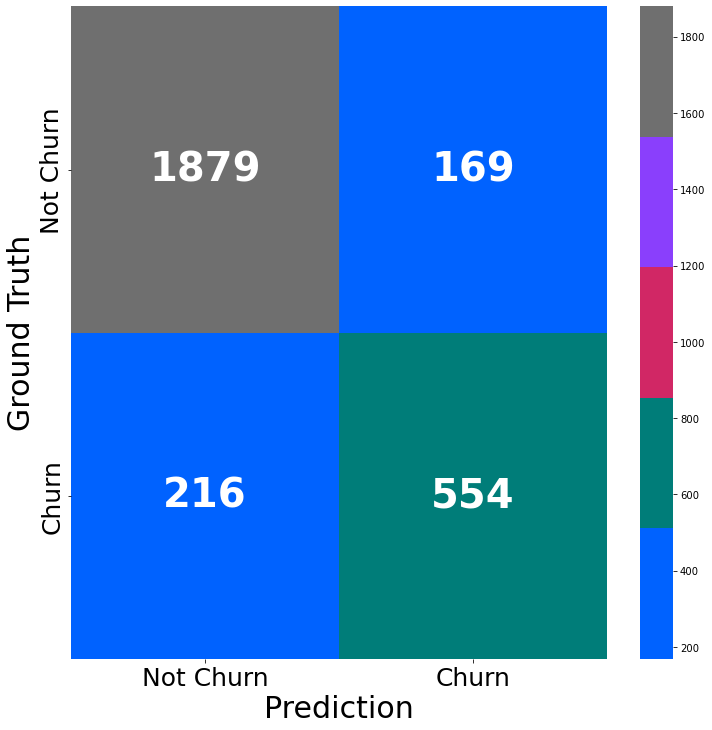

In [39]:
# Plot confusion matrix
sns.set_palette(sns.color_palette(colors))
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap=colors, annot_kws={"size": 40, "weight": "bold"})  
labels = ['Not Churn', 'Churn']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels, fontsize=25);
ax.set_xlabel('Prediction', fontsize=30);
ax.set_ylabel('Ground Truth', fontsize=30)
### END SOLUTION

## Question 5
* Using the same split of training and test samples, estimate another K-Nearest Neighbors model
* This time, use K=5 and weight the results by distance
* Again, examine the Precision, Recall, F-1 Score, and Accuracy of the classification, and visualize the Confusion Matrix. 

In [40]:
### BEGIN SOLUTION
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2048
           1       0.78      0.74      0.76       770

    accuracy                           0.87      2818
   macro avg       0.84      0.83      0.84      2818
weighted avg       0.87      0.87      0.87      2818

Accuracy score:  0.87
F1 Score:  0.76


Text(87.0, 0.5, 'Ground Truth')

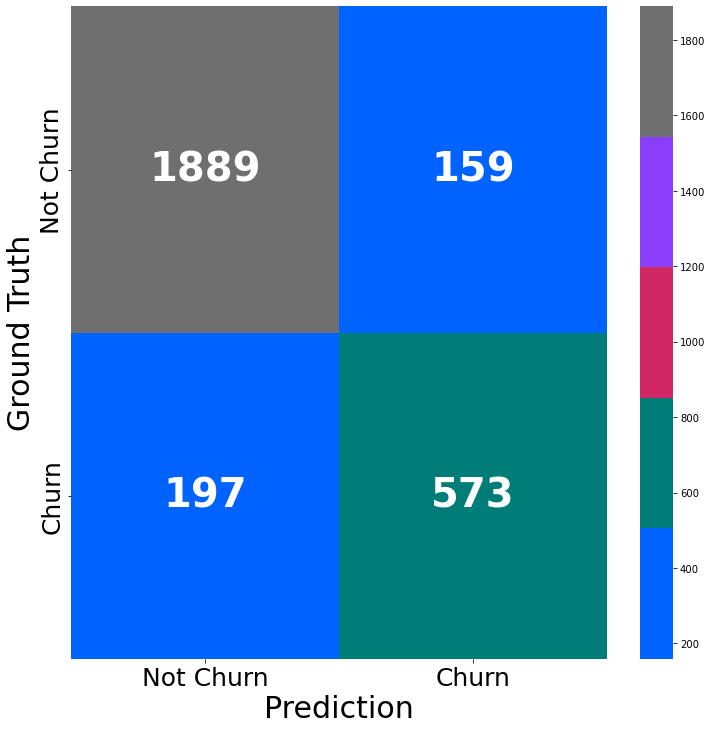

In [41]:
# Plot confusion matrix
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap=colors, annot_kws={"size": 40, "weight": "bold"})  
labels = ['Not Churn', 'Churn']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels, fontsize=25);
ax.set_xlabel('Prediction', fontsize=30);
ax.set_ylabel('Ground Truth', fontsize=30)
### END SOLUTION

## Question 6
* To determine the right value for K, examing results for values of K from 1 to 40.
* This time, focus on two measures, the F-1 Score, and the Error Rate (1-Accuracy)
* Generate charts which plot each of these measures as a function of K. 
* What do these charts suggest about the optimal value for K?

In [42]:
### BEGIN SOLUTION
max_k = 40
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4))) # Appending tuples
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))  # Appending tuples
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score']) # Converting list of tuples into a dataframe
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate']) # Converting list of tuples into a dataframe

In [43]:
f1_results

,K,F1 Score
0,1,0.7211
1,2,0.7221
2,3,0.7492
3,4,0.7555
4,5,0.7630
5,6,0.7694
6,7,0.7609
7,8,0.7698
8,9,0.7740
9,10,0.7769


In [44]:
error_results

,K,Error Rate
0,1,0.1540
1,2,0.1529
2,3,0.1338
3,4,0.1302
4,5,0.1263
5,6,0.1221
6,7,0.1249
7,8,0.1210
8,9,0.1185
9,10,0.1167


<Figure size 1800x1200 with 0 Axes>

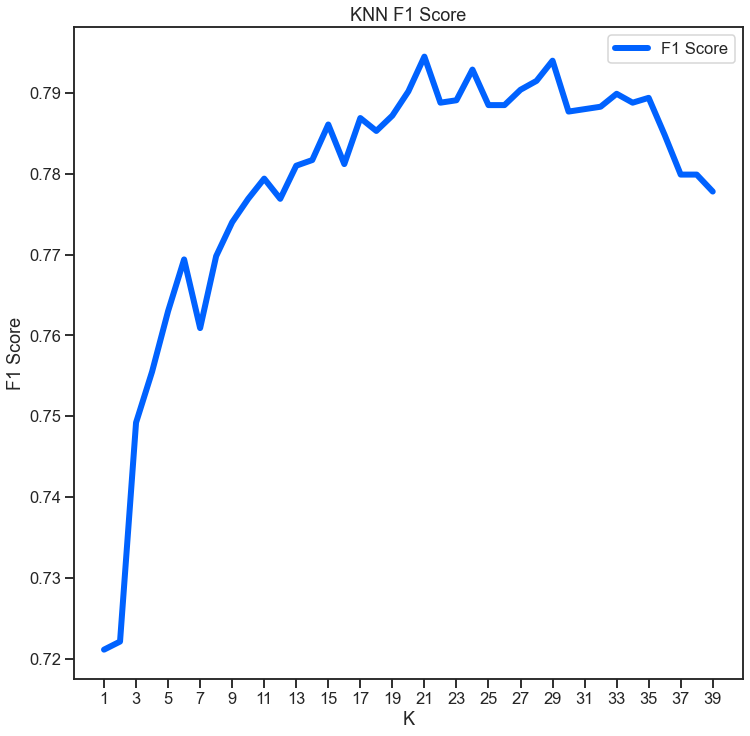

In [45]:
# Plot F1 results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(color=colors[0], figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

<Figure size 1800x1200 with 0 Axes>

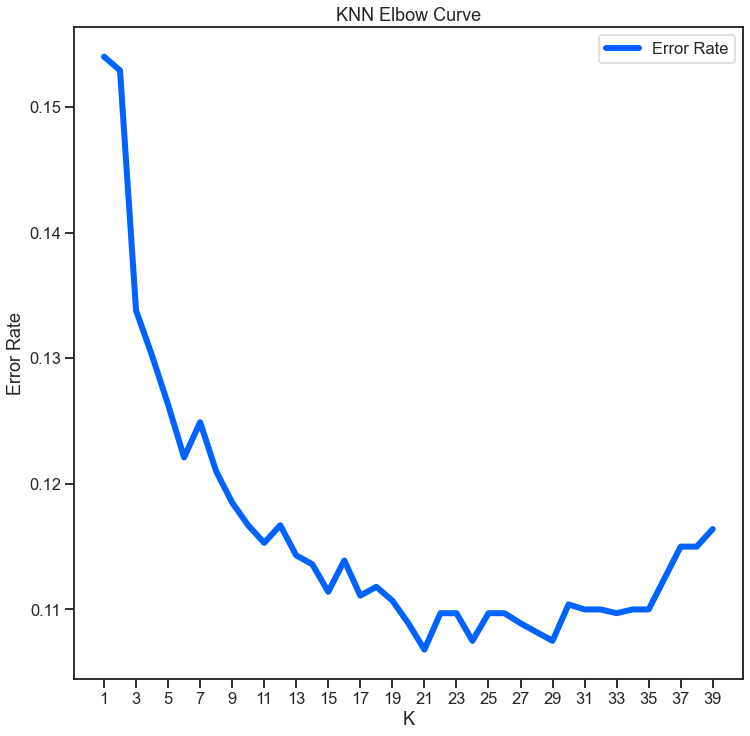

In [46]:
# Plot Accuracy (Error Rate) results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot(color=colors[0], figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve')
plt.savefig('knn_elbow.png')
### END SOLUTION

---
### Machine Learning Foundation (C) 2020 IBM Corporation